In [352]:
#imports
import h5py
import torch
import pandas as pd
import numpy as np
from tangermeme.utils import characters
from tangermeme.seqlet import tfmodisco_seqlets
from tangermeme.plot import plot_logo
from tangermeme.utils import one_hot_encode
from tangermeme.deep_lift_shap import deep_lift_shap, _nonlinear
import torch, torch.nn as nn, torch.fx as fx, copy
import copy
import matplotlib.pyplot as plt

In [591]:
import h5py
import numpy as np

src_path = '/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/SEAM_analysis/Hk_SEAM_results/Hk_task1_attributions.h5'
dst_path = "/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/SEAM_analysis/Hk_SEAM_results/Hk_task1_attributions_cleaned.h5"
bad_index = 5155  # corrupted entry

with h5py.File(src_path, "r") as fsrc, h5py.File(dst_path, "w") as fdst:
    dset = fsrc["attributions"]
    n = dset.shape[0]
    rest_shape = dset.shape[1:]

    # Determine which indices to keep
    keep_indices = np.array([i for i in range(n) if i != bad_index], dtype=np.int32)

    # Create new dataset for cleaned data
    clean_dset = fdst.create_dataset(
        "attributions",
        shape=(len(keep_indices), *rest_shape),
        dtype=dset.dtype,
        chunks=dset.chunks
    )

    # Copy everything except the corrupted one
    print(f"Copying 0:{bad_index} ...")
    clean_dset[0:bad_index] = dset[0:bad_index]

    print(f"Copying {bad_index+1}:{n} ...")
    clean_dset[bad_index:] = dset[bad_index + 1 : n]

    # Save mapping to original indices
    fdst.create_dataset("original_indices", data=keep_indices)

print(f"✅ Cleaned file written to {dst_path}")
print(f"🧭 Stored {len(keep_indices)} valid entries (skipped {bad_index})")


Copying 0:5155 ...
Copying 5156:9000 ...
✅ Cleaned file written to /grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/SEAM_analysis/Hk_SEAM_results/Hk_task1_attributions_cleaned.h5
🧭 Stored 8999 valid entries (skipped 5155)


In [592]:
def load_scaled_foreground_with_original_indices(h5_file_path):
    """
    Load scaled foreground attributions while preserving original sequence indices
    """
    with h5py.File(h5_file_path, 'r') as f:
        # Load the attribution data (shape: 8999, 3, 249, 4)
        all_attributions = f['attributions'][:]
        
        # Load the original indices mapping (shape: 8999,)
        original_indices = f['original_indices'][:]
        
        # Extract scaled foreground (index 1)
        scaled_foreground_attr = torch.tensor(all_attributions[:, 1, :, :], dtype=torch.float32)
        cluster_foreground_attr = torch.tensor(all_attributions[:, 0, :, :], dtype=torch.float32)
        
        print(f"Loaded {len(scaled_foreground_attr)} sequences")
        print(f"Original indices range: {original_indices.min()} to {original_indices.max()}")
        print(f"Skipped original index: 5155" if 5155 not in original_indices else "Index 5155 present")
        
        return scaled_foreground_attr, original_indices, cluster_foreground_attr

In [593]:
h5_file_path = '/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/SEAM_analysis/Hk_SEAM_results/Hk_task1_attributions_cleaned.h5'
scaled_foreground_attr, original_indices, cluster_foreground_attr = load_scaled_foreground_with_original_indices(h5_file_path)

print(scaled_foreground_attr.shape)

Loaded 8999 sequences
Original indices range: 0 to 8999
Skipped original index: 5155
torch.Size([8999, 249, 4])


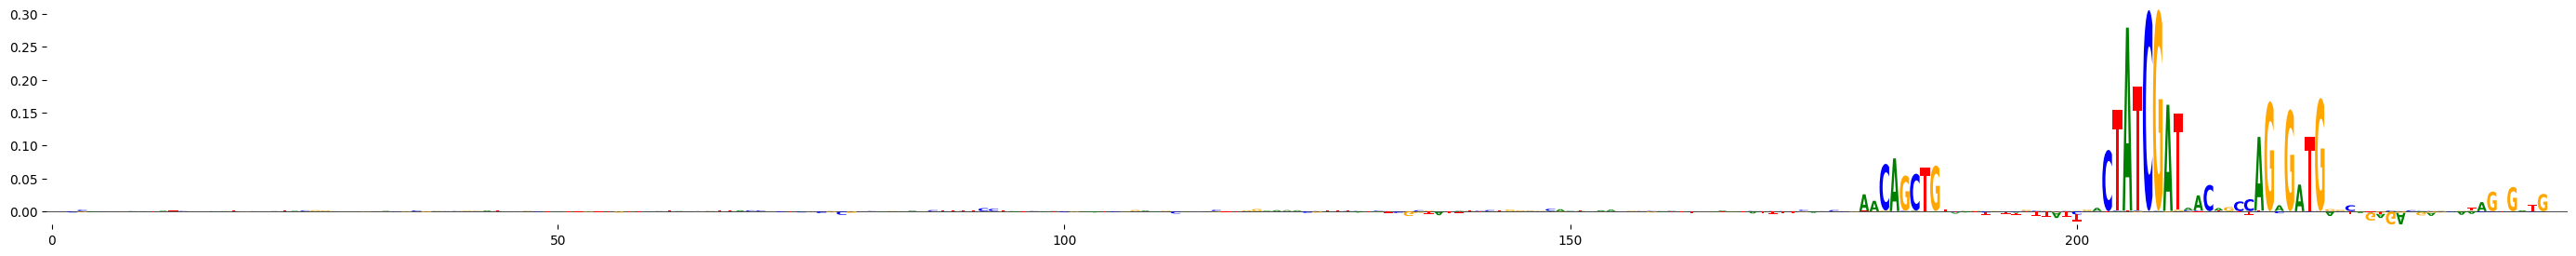

In [598]:
fig, ax = plt.subplots(figsize=(35, 3))
plot_logo(scaled_foreground_attr[8500].T, ax=ax)
plt.show()


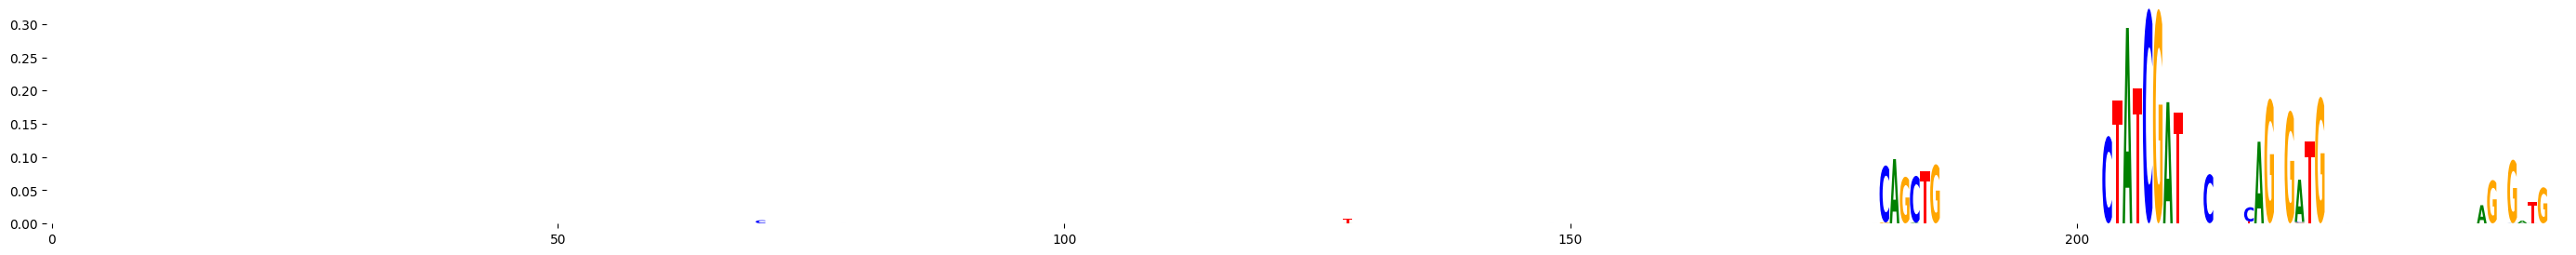

In [596]:
fig, ax = plt.subplots(figsize=(35, 3))
plot_logo(cluster_foreground_attr[8500].T, ax=ax)
plt.show()


In [599]:
def input_x_attribution(foreground_attr, original_indices):
    """
    Multiply one-hot encoded sequences by attribution maps
    Properly handles index mapping between cleaned data and original sequences
    """
    orig_df = pd.read_csv('/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/experimental_library_generation/Binned_libraries/Hk_final_df.csv')
    inxatt_list = []
    
    # Create a mapping for tracking
    index_mapping = []
    
    for pos_idx, orig_idx in enumerate(original_indices):
        if pos_idx % 1000 == 0:
            print(f"Processing position {pos_idx}/{len(original_indices)} -> original sequence {orig_idx}")
        
        # Get the one-hot encoded sequence for this original index
        onehot_seq = orig_df.iloc[orig_idx]['Sequence']
        onehot_seq = one_hot_encode(onehot_seq)
        
        # Use pos_idx to index foreground_attr (position in cleaned array)
        # Use orig_idx to get the correct sequence from CSV
        inxatt = (onehot_seq.T * foreground_attr[pos_idx]).sum(dim=1)
        #inxatt = (onehot_seq.T * foreground_attr[pos_idx])
        
        inxatt_list.append(inxatt)
        index_mapping.append({
            'position_in_cleaned': pos_idx,
            'original_sequence_idx': orig_idx
        })
    
    inXatt = torch.stack(inxatt_list)
    
    print(f"Created inXatt with shape: {inXatt.shape}")
    print(f"Index mapping created for tracking back to original sequences")
    
    return inXatt, index_mapping

# Now run tfmodisco

In [615]:
print(index_mapping[5153:5157])

[{'position_in_cleaned': 5153, 'original_sequence_idx': 5153}, {'position_in_cleaned': 5154, 'original_sequence_idx': 5154}, {'position_in_cleaned': 5155, 'original_sequence_idx': 5156}, {'position_in_cleaned': 5156, 'original_sequence_idx': 5157}]


In [600]:
inXatt, index_mapping = input_x_attribution(scaled_foreground_attr, original_indices)
print(len(inXatt))

Processing position 0/8999 -> original sequence 0
Processing position 1000/8999 -> original sequence 1000
Processing position 2000/8999 -> original sequence 2000
Processing position 3000/8999 -> original sequence 3000
Processing position 4000/8999 -> original sequence 4000
Processing position 5000/8999 -> original sequence 5000
Processing position 6000/8999 -> original sequence 6001
Processing position 7000/8999 -> original sequence 7001
Processing position 8000/8999 -> original sequence 8001
Created inXatt with shape: torch.Size([8999, 249])
Index mapping created for tracking back to original sequences
8999


In [601]:
# Now run tfmodisco
print("Running tfmodisco...")
seqlets = tfmodisco_seqlets(
    X_attr=inXatt,
    window_size=20,
    flank=5)


Running tfmodisco...


In [602]:
print(seqlets.shape)
seqlets[seqlets['example_idx'] == 7991]

(10078, 4)


,example_idx,start,end,attribution
7306,7991,105,135,3.944725
7307,7991,89,119,0.994679
7308,7991,121,151,0.988010


In [603]:

print(seqlets.shape)
seqlets[seqlets['example_idx'] == 264]

(10078, 4)


,example_idx,start,end,attribution
83,264,124,154,-0.104167


In [605]:
## add bin to seqlets
# Simple bin assignment
orig_df = pd.read_csv('/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/experimental_library_generation/Binned_libraries/Hk_final_df.csv')

bins = []
real_scores = []
evoaug_scores = []

# Assign bins to seqlets
for i in range(len(seqlets)):
    cleaned_pos = int(seqlets.iloc[i]['example_idx'])
    orig_seq_idx = index_mapping[cleaned_pos]['original_sequence_idx']

    bins.append(orig_df.iloc[orig_seq_idx]['EvoAug_Score_Hk_bin'])
    real_scores.append(orig_df.iloc[orig_seq_idx]['Real_Score_Hk'])
    evoaug_scores.append(orig_df.iloc[orig_seq_idx]['EvoAug_Score_Hk'])

seqlets['bin'] = bins
seqlets['real_score'] = real_scores
seqlets['evoaug_score'] = evoaug_scores
print(f"Bin counts: {seqlets['bin'].value_counts()}")

# Quick verification
seqlets[seqlets['bin']=='Low'].sort_values(by='attribution', ascending=False).head(30)

Bin counts: bin
High    8193
Mid      959
Low      926
Name: count, dtype: int64


,example_idx,start,end,attribution,bin,real_score,evoaug_score
3877,4679,215,245,0.704672,Low,2.849202,-1.085390
174,551,111,141,0.485263,Low,-3.165311,-1.159644
3863,4637,188,218,0.446394,Low,1.030062,-1.331508
115,363,86,116,-0.103383,Low,-0.752235,-1.330092
3671,4021,112,142,-0.103407,Low,-1.015850,-1.206794
90,275,153,183,-0.103418,Low,0.285900,-1.300316
53,165,132,162,-0.103428,Low,-1.428345,-1.625581
3452,3223,183,213,-0.103453,Low,-1.860456,-1.278128
3732,4238,77,107,-0.103454,Low,-1.445419,-1.118223
3922,4839,71,101,-0.103492,Low,-0.420691,-1.230137


In [673]:
seqlets.sort_values(by='attribution', ascending=False).head()

,example_idx,start,end,attribution,bin,real_score,evoaug_score
7306,7991,105,135,3.944725,High,5.449725,5.282654
6427,7665,109,139,3.909916,High,5.700001,5.342895
8102,8285,106,136,3.858745,High,4.155668,4.550573
8182,8313,107,137,3.761283,High,5.416411,5.321619
6181,7569,125,155,3.753686,High,5.547552,4.119169


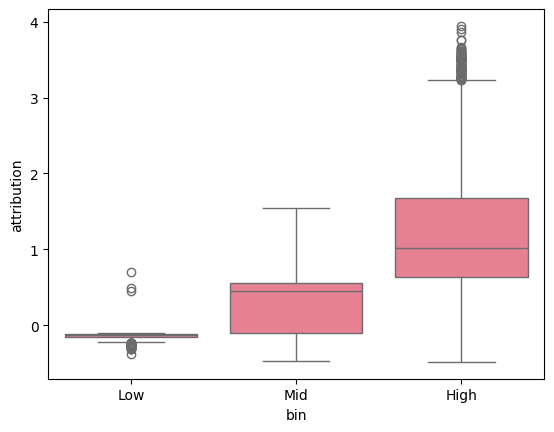

In [606]:
import seaborn as sns
sns.boxplot(x='bin', y='attribution', data=seqlets)
plt.show()

In [337]:
import os, sys
model_dir  = "/grid/wsbs/home_norepl/pmantill/Trained_Model_Zoo/EvoAug_Distilled_Student_Model"
model_path = os.path.join(model_dir, "EvoAug_student_model.pt")

# Make sure distill_EvoAug2.py is in model_dir
sys.path.insert(0, model_dir)
import distill_EvoAug2 as distill_mod  # avoid shadowing 'model'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pytorch_model = torch.load(model_path, map_location=device).to(device).eval()

In [347]:
# Wrap to expose only the mean head (B,2)
class MeanOnlyModel(nn.Module):
    def __init__(self, student_model): 
        super().__init__()
        self.student = student_model
    def forward(self, X):
        out = self.student(X)   # dict
        return out["mean"]      # (B,2)

def uniquify_relu_calls(model: nn.Module) -> nn.Module:
    gm = fx.symbolic_trace(model)
    modules = dict(gm.named_modules())
    counter = 0
    for node in gm.graph.nodes:
        if node.op == 'call_module' and isinstance(modules[node.target], nn.ReLU):
            new_name = f"_relu_callsite_{counter}"
            counter += 1
            setattr(gm, new_name, nn.ReLU(inplace=False))
            node.target = new_name
    gm.recompile()
    return gm.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Will use GPU 3 due to CUDA_VISIBLE_DEVICES
pytorch_model.to(device).eval()

attr_model = MeanOnlyModel(pytorch_model).eval()
attr_model = copy.deepcopy(attr_model).eval()
attr_model = uniquify_relu_calls(attr_model).to(device).eval()

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


def deeplift_attr_with_progress(x_np_BLA, target_idx, batch_size, n_shuffles):
    B, L, A = x_np_BLA.shape
    out = np.empty((B, L, A), dtype=np.float16)
    for s in range(0, B, batch_size):
        e = min(s + batch_size, B)
        x_batch = x_np_BLA[s:e]  # (b, L, A)
        x_t = torch.from_numpy(np.ascontiguousarray(x_batch)).to(device, dtype=torch.float32)
        x_t = x_t.permute(0, 2, 1).contiguous()          # -> (b, A, L)
        x_t.requires_grad_(True)                         # CRITICAL
        #print(target_idx)
        # IMPORTANT: do NOT wrap this in no_grad/inference_mode
        
        attr_BAL = deep_lift_shap(
            attr_model,
            x_t,
            target=target_idx,                # 0=Dev, 1=HK
            device='cuda',
            batch_size=x_t.shape[0],
            n_shuffles=n_shuffles,
            print_convergence_deltas=False,
            additional_nonlinear_ops={nn.ReLU: _nonlinear},
            verbose=True
        )

        attr_BLA = attr_BAL.permute(0, 2, 1).contiguous().cpu().detach().numpy()  # -> (b, L, A)
        out[s:e] = attr_BLA.astype(np.float16)

    return out

In [608]:
# Restore 4-channel shape preserving correct indexing
inXatt_4channel = torch.zeros(len(inXatt), 249, 4)

for i in range(len(inXatt)):
    # Get the original sequence index for this position
    orig_seq_idx = index_mapping[i]['original_sequence_idx']
    sequence = orig_df.iloc[orig_seq_idx]['Sequence']
    
    for pos in range(249):
        nucleotide = sequence[pos]
        attr_val = inXatt[i, pos]
        
        if nucleotide == 'A':
            inXatt_4channel[i, pos, 0] = attr_val
        elif nucleotide == 'C':
            inXatt_4channel[i, pos, 1] = attr_val
        elif nucleotide == 'G':
            inXatt_4channel[i, pos, 2] = attr_val
        elif nucleotide == 'T':
            inXatt_4channel[i, pos, 3] = attr_val

print(f"Original shape: {inXatt.shape}")
print(f"Restored shape: {inXatt_4channel.shape}")

Original shape: torch.Size([8999, 249])
Restored shape: torch.Size([8999, 249, 4])


Cleaned position: 8313, Original sequence index: 8314
torch.Size([249, 4])


100%|██████████| 523/523 [00:03<00:00, 142.86it/s]


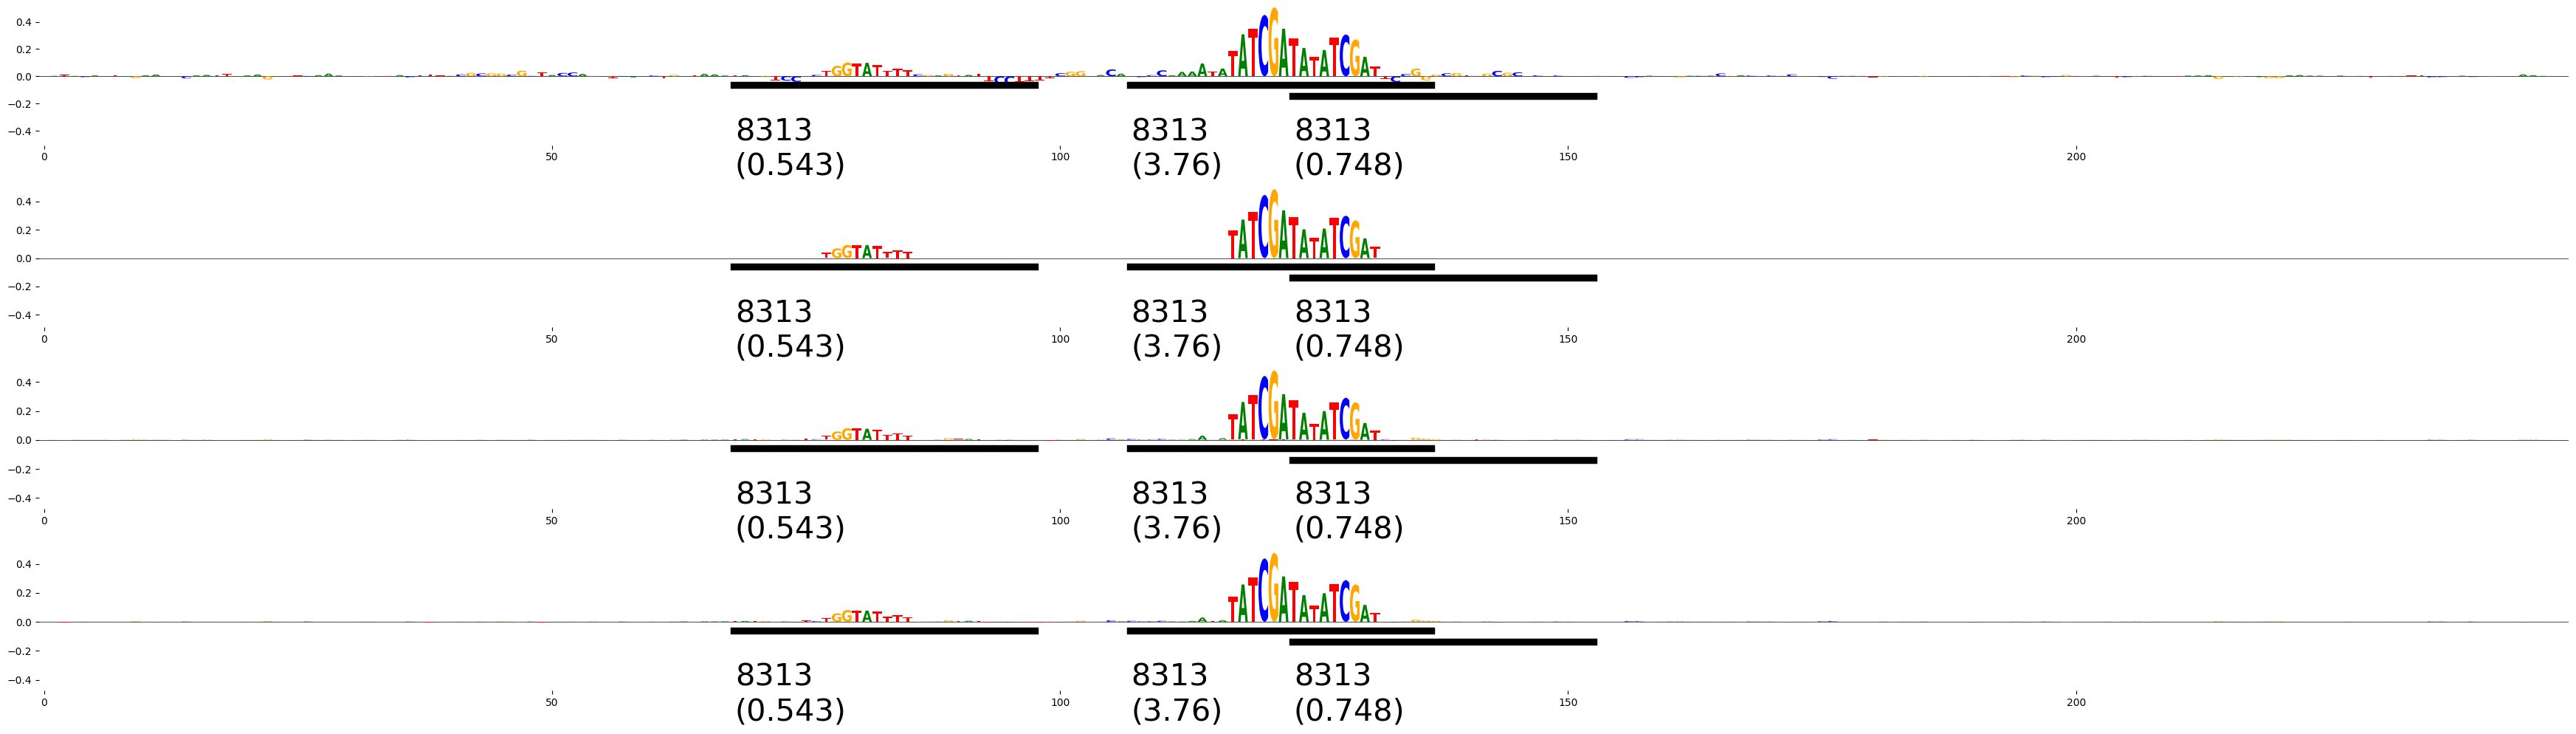

In [674]:
fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

seq_i = 8313  # cleaned position
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
print(f"Cleaned position: {seq_i}, Original sequence index: {orig_seq_idx}")
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=5096,              # increased for H100 80GB
        n_shuffles=523                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

# FIXED: Use consistent indexing
plot_logo(attributions.T, ax=ax[0], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()

Cleaned position: 3131, Original sequence index: 3131
torch.Size([249, 4])


100%|██████████| 526/526 [00:02<00:00, 178.10it/s]


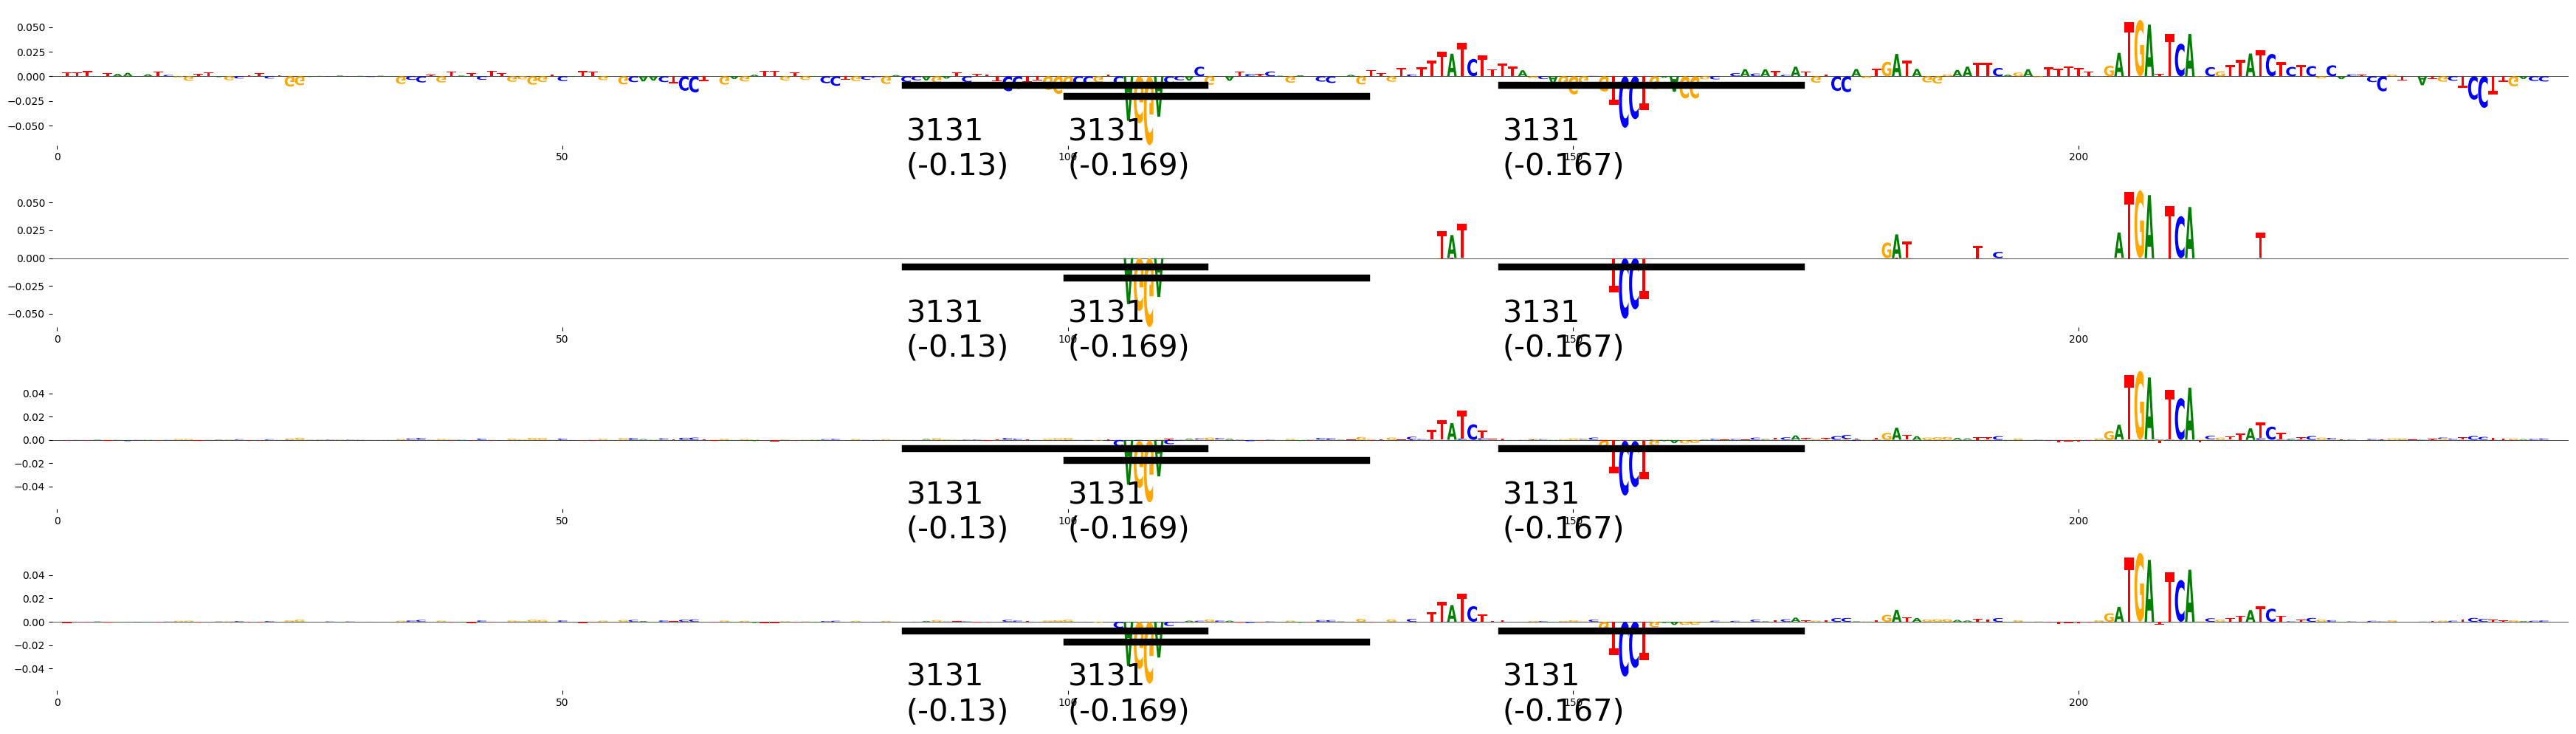

In [656]:
seq_i = 3131  # cleaned position
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
print(f"Cleaned position: {seq_i}, Original sequence index: {orig_seq_idx}")
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=5096,              # increased for H100 80GB
        n_shuffles=526                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

# FIXED: Use consistent indexing
plot_logo(attributions.T, ax=ax[0], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()

Cleaned position: 8998, Original sequence index: 8999
torch.Size([249, 4])


100%|██████████| 523/523 [00:02<00:00, 180.46it/s]


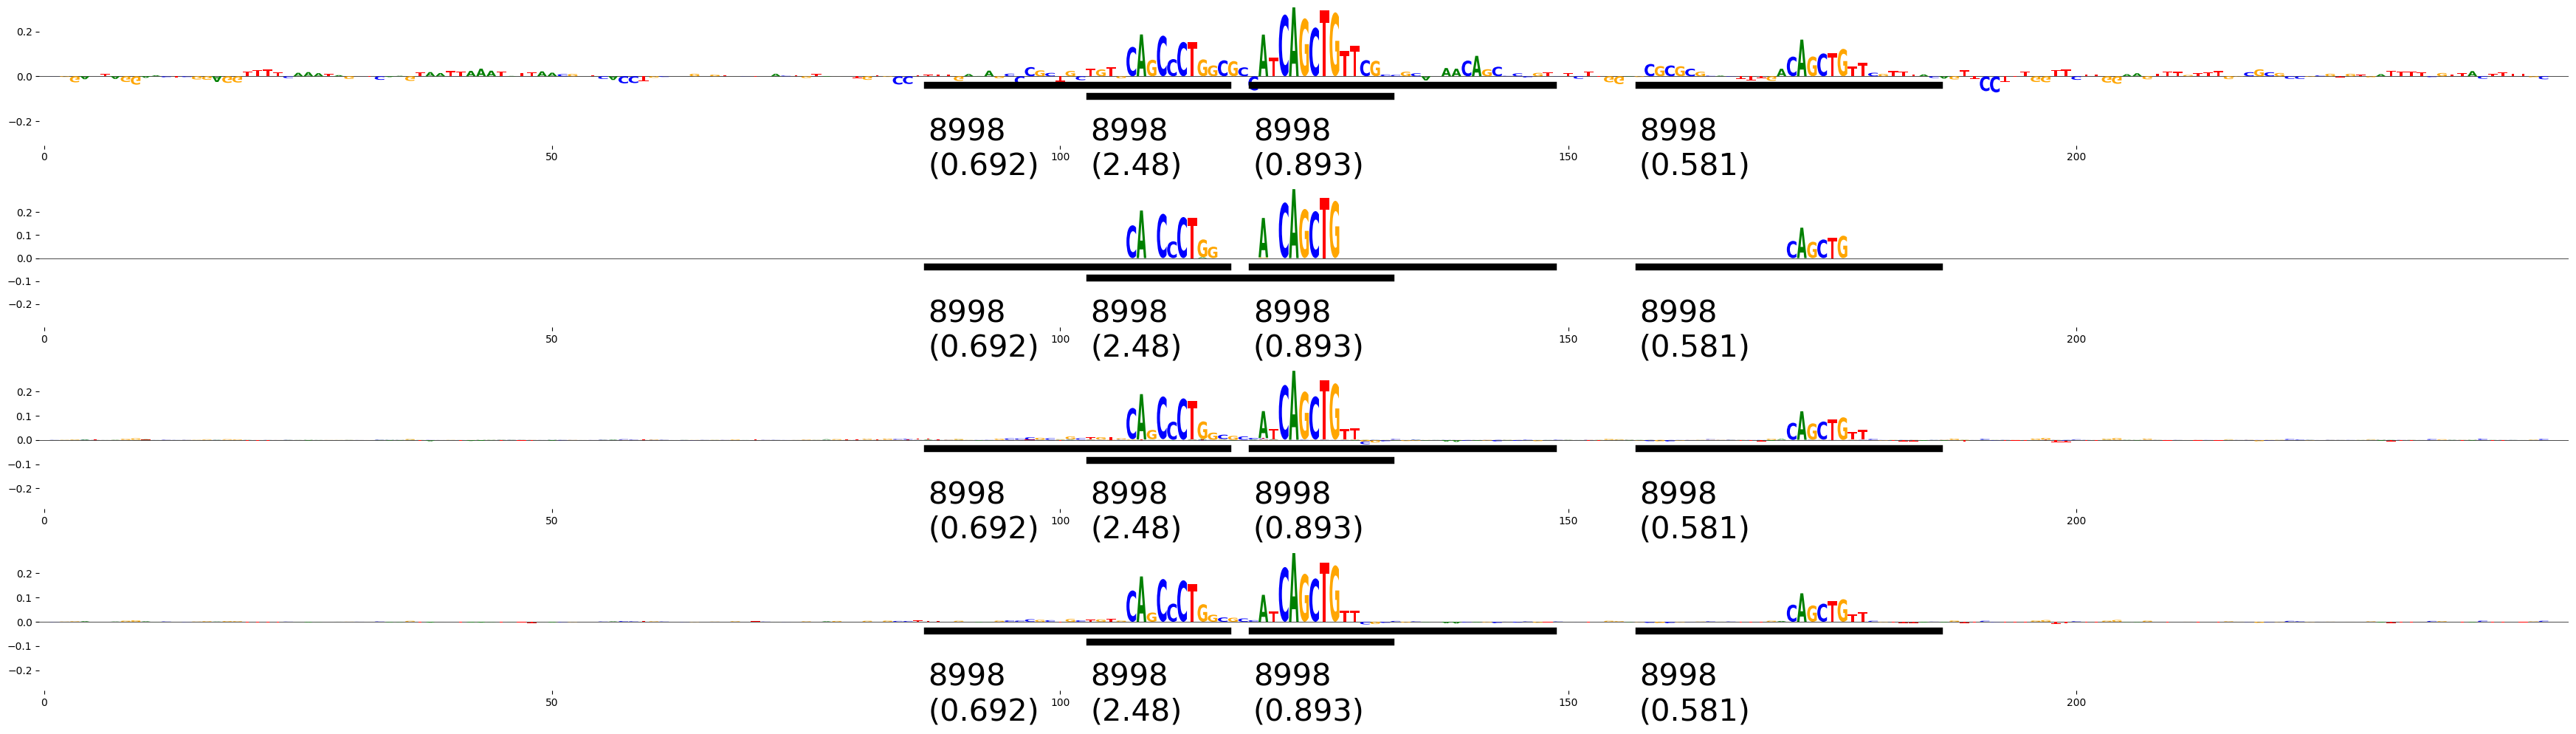

In [662]:
seq_i = 8998  # cleaned position
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
print(f"Cleaned position: {seq_i}, Original sequence index: {orig_seq_idx}")
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=500,              # increased for H100 80GB
        n_shuffles=523                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

# FIXED: Use consistent indexing
plot_logo(attributions.T, ax=ax[0], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()

torch.Size([249, 4])


100%|██████████| 523/523 [00:02<00:00, 186.78it/s]


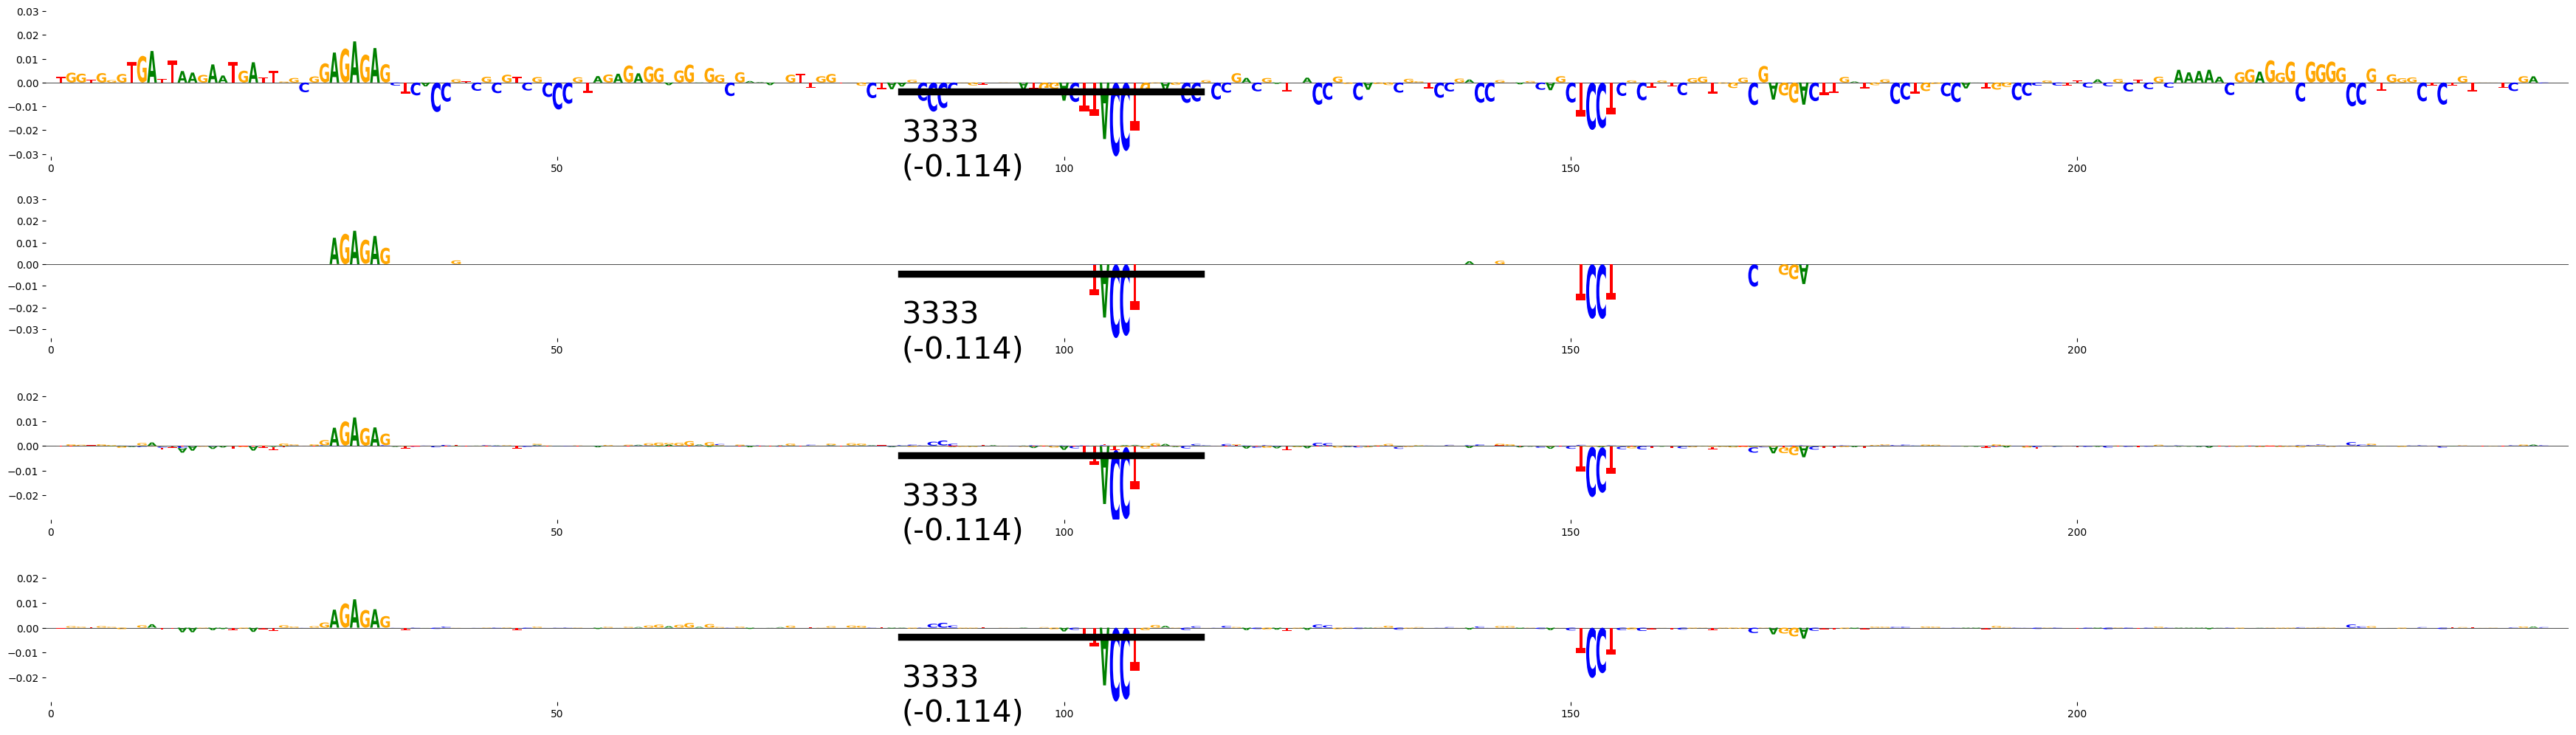

In [668]:
seq_i = 3333  # cleaned position
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=550,              # increased for H100 80GB
        n_shuffles=523                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

plot_logo(attributions.T, ax=ax[0], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plt.tight_layout()
plt.show()

Cleaned position: 8796, Original sequence index: 8797
torch.Size([249, 4])


100%|██████████| 23/23 [00:00<00:00, 173.20it/s]


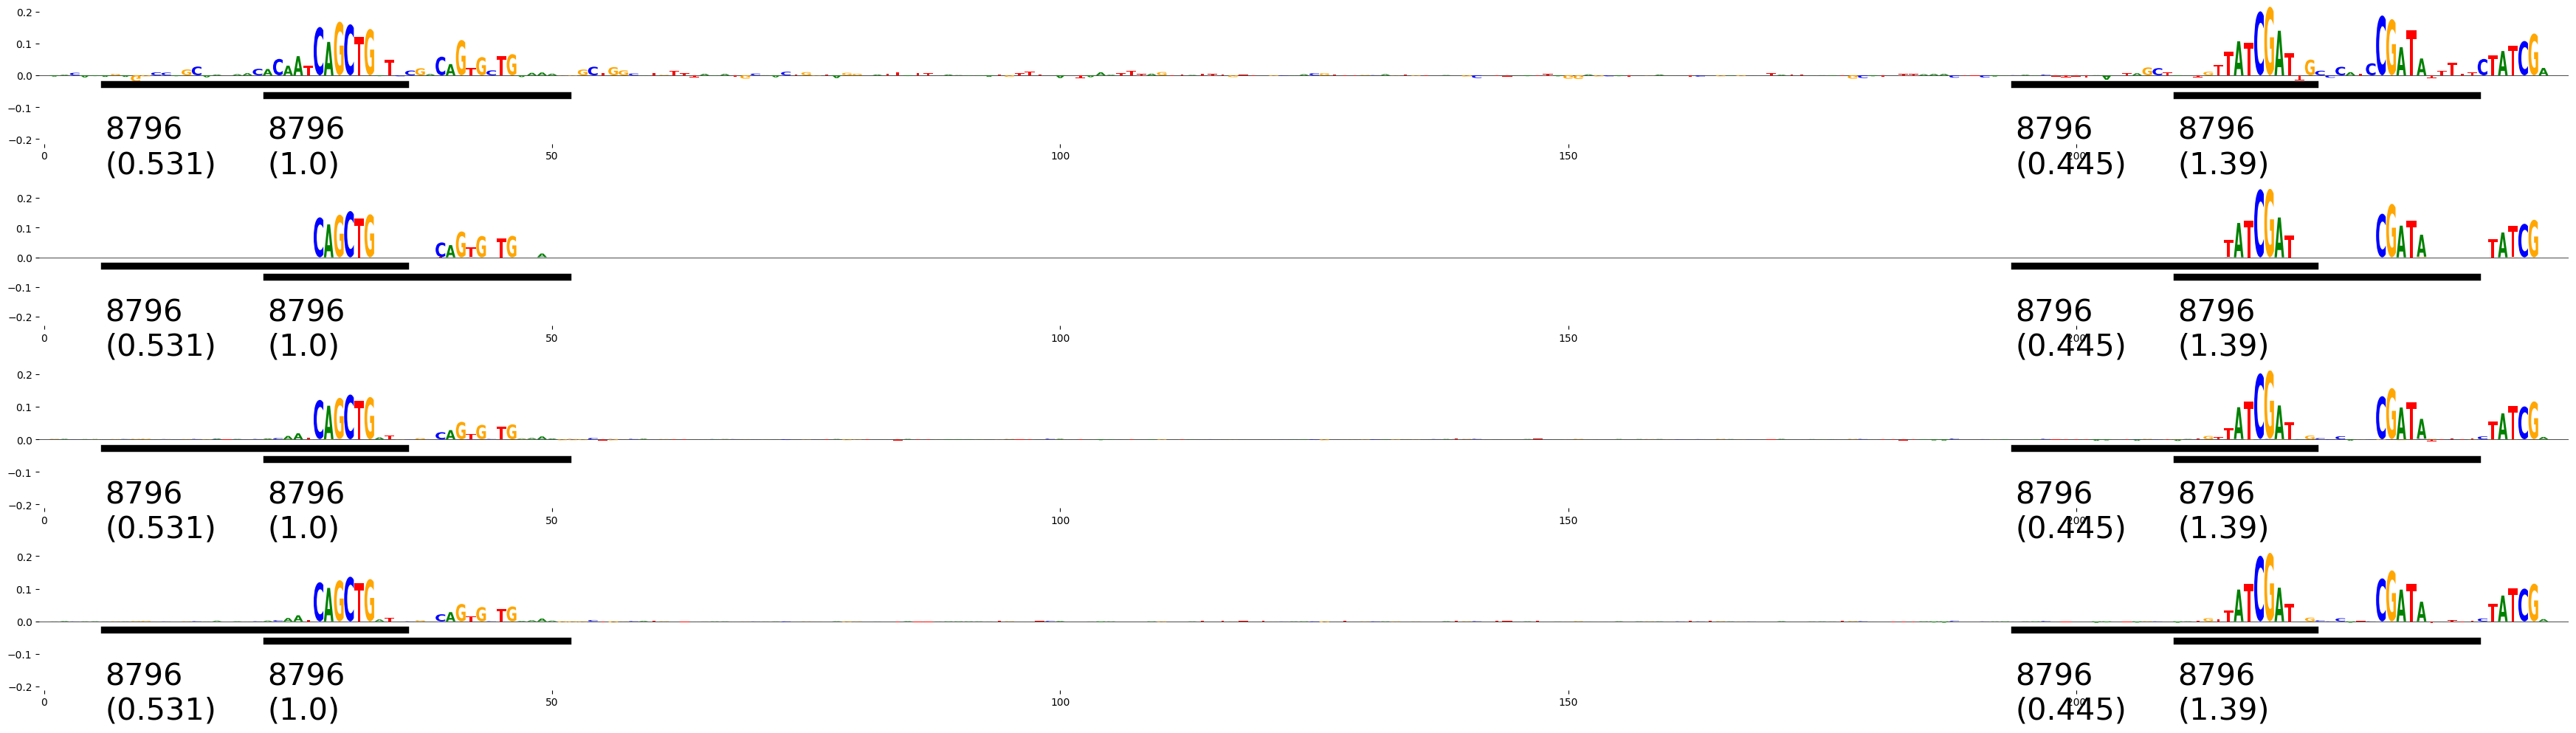

In [667]:
seq_i = 8796  # cleaned position
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
print(f"Cleaned position: {seq_i}, Original sequence index: {orig_seq_idx}")
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=500,              # increased for H100 80GB
        n_shuffles=23                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

# FIXED: Use seq_i (cleaned position) for ALL data structures
# inXatt_4channel is also indexed by cleaned positions (i), not original sequence indices
plot_logo(attributions.T, ax=ax[0], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()

Cleaned position: 1280, Original sequence index: 1280
torch.Size([249, 4])


100%|██████████| 23/23 [00:00<00:00, 177.66it/s]


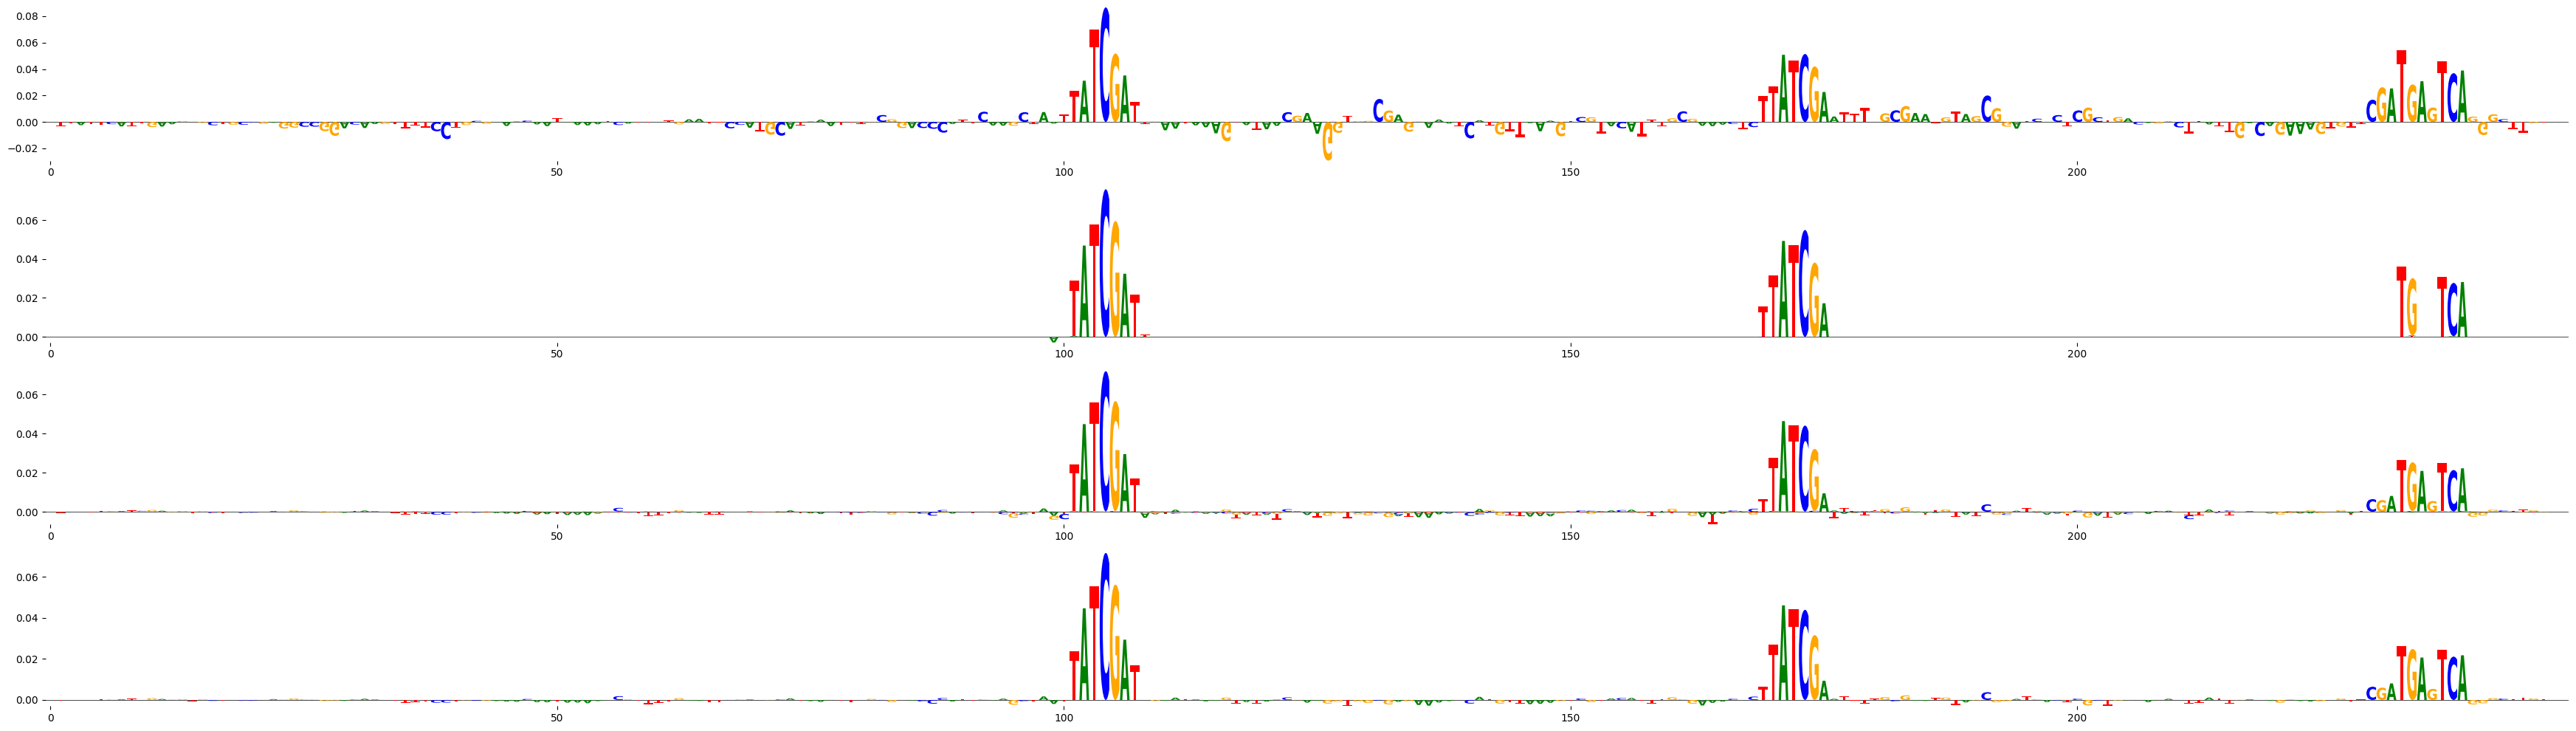

In [675]:
seq_i = 1280  # cleaned position
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
print(f"Cleaned position: {seq_i}, Original sequence index: {orig_seq_idx}")
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=500,              # increased for H100 80GB
        n_shuffles=23                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

# FIXED: Use seq_i (cleaned position) for ALL data structures
# inXatt_4channel is also indexed by cleaned positions (i), not original sequence indices
plot_logo(attributions.T, ax=ax[0], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=seqlets[seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()

In [575]:
# Start from the original data - filter by Low bin first
low_bin_indices = orig_df[orig_df['EvoAug_Score_Hk_bin'] == 'Low'].index.tolist()

# Map these original indices to cleaned positions
low_cleaned_positions = []
for orig_idx in low_bin_indices:
    if orig_idx in original_indices:  # Make sure this sequence wasn't removed
        cleaned_pos = np.where(original_indices == orig_idx)[0][0]
        low_cleaned_positions.append(cleaned_pos)

# Sort to maintain order
low_cleaned_positions.sort()

# Subset the attribution tensor to only Low bin sequences
low_inXatt = inXatt[low_cleaned_positions]

print(f"Total Low bin sequences in original data: {len(low_bin_indices)}")
print(f"Low bin sequences in cleaned data: {len(low_cleaned_positions)}")
print(f"Low bin attribution tensor shape: {low_inXatt.shape}")

# Restore 4-channel shape for low_inXatt only
inXatt_4channel = torch.zeros(len(low_inXatt), 249, 4)

for i, cleaned_pos in enumerate(low_cleaned_positions):
    sequence = orig_df.iloc[original_indices[cleaned_pos]]['Sequence']
    
    for pos in range(249):
        nucleotide = sequence[pos]
        attr_val = low_inXatt[i, pos]
        
        if nucleotide == 'A':
            inXatt_4channel[i, pos, 0] = attr_val
        elif nucleotide == 'C':
            inXatt_4channel[i, pos, 1] = attr_val
        elif nucleotide == 'G':
            inXatt_4channel[i, pos, 2] = attr_val
        elif nucleotide == 'T':
            inXatt_4channel[i, pos, 3] = attr_val

print(f"Final shape: {inXatt_4channel.shape}")

Total Low bin sequences in original data: 3000
Low bin sequences in cleaned data: 3000
Low bin attribution tensor shape: torch.Size([3000, 249])
Final shape: torch.Size([3000, 249, 4])


In [577]:

print(f"Total Low bin sequences in original data: {len(low_bin_indices)}")
print(f"Low bin sequences in cleaned data: {len(low_cleaned_positions)}")
print(f"Low bin attribution tensor shape: {low_inXatt.shape}")

# Now run tfmodisco on ALL Low bin sequences
low_seqlets = tfmodisco_seqlets(
    X_attr=low_inXatt,
    window_size=20,
    flank=5
)

print(f"Found {len(low_seqlets)} seqlets from Low bin")
low_seqlets.sort_values(by='attribution', ascending=False)

Total Low bin sequences in original data: 3000
Low bin sequences in cleaned data: 3000
Low bin attribution tensor shape: torch.Size([3000, 249])
Found 2245 seqlets from Low bin


,example_idx,start,end,attribution
1995,2679,215,245,0.704672
412,551,111,141,0.485263
1959,2637,188,218,0.446394
63,97,217,247,0.363570
844,1131,198,228,0.363203
...,...,...,...,...
94,136,99,129,-0.309293
330,442,72,102,-0.309570
1336,1819,84,114,-0.309823
980,1292,114,144,-0.312603


In [578]:
# Restore 4-channel shape preserving correct indexing
inXatt_4channel = torch.zeros(len(low_inXatt), 249, 4)

for i in range(len(low_inXatt)):
    # Get the original sequence index for this position
    orig_seq_idx = index_mapping[i]['original_sequence_idx']
    sequence = orig_df.iloc[orig_seq_idx]['Sequence']
    
    for pos in range(249):
        nucleotide = sequence[pos]
        attr_val = inXatt[i, pos]
        
        if nucleotide == 'A':
            inXatt_4channel[i, pos, 0] = attr_val
        elif nucleotide == 'C':
            inXatt_4channel[i, pos, 1] = attr_val
        elif nucleotide == 'G':
            inXatt_4channel[i, pos, 2] = attr_val
        elif nucleotide == 'T':
            inXatt_4channel[i, pos, 3] = attr_val

print(f"Original shape: {low_inXatt.shape}")
print(f"Restored shape: {inXatt_4channel.shape}")

Original shape: torch.Size([3000, 249])
Restored shape: torch.Size([3000, 249, 4])


Found 1 seqlets for low position 1643
Using low sequence position 0 as example
torch.Size([249, 4])


100%|██████████| 523/523 [00:03<00:00, 174.03it/s]


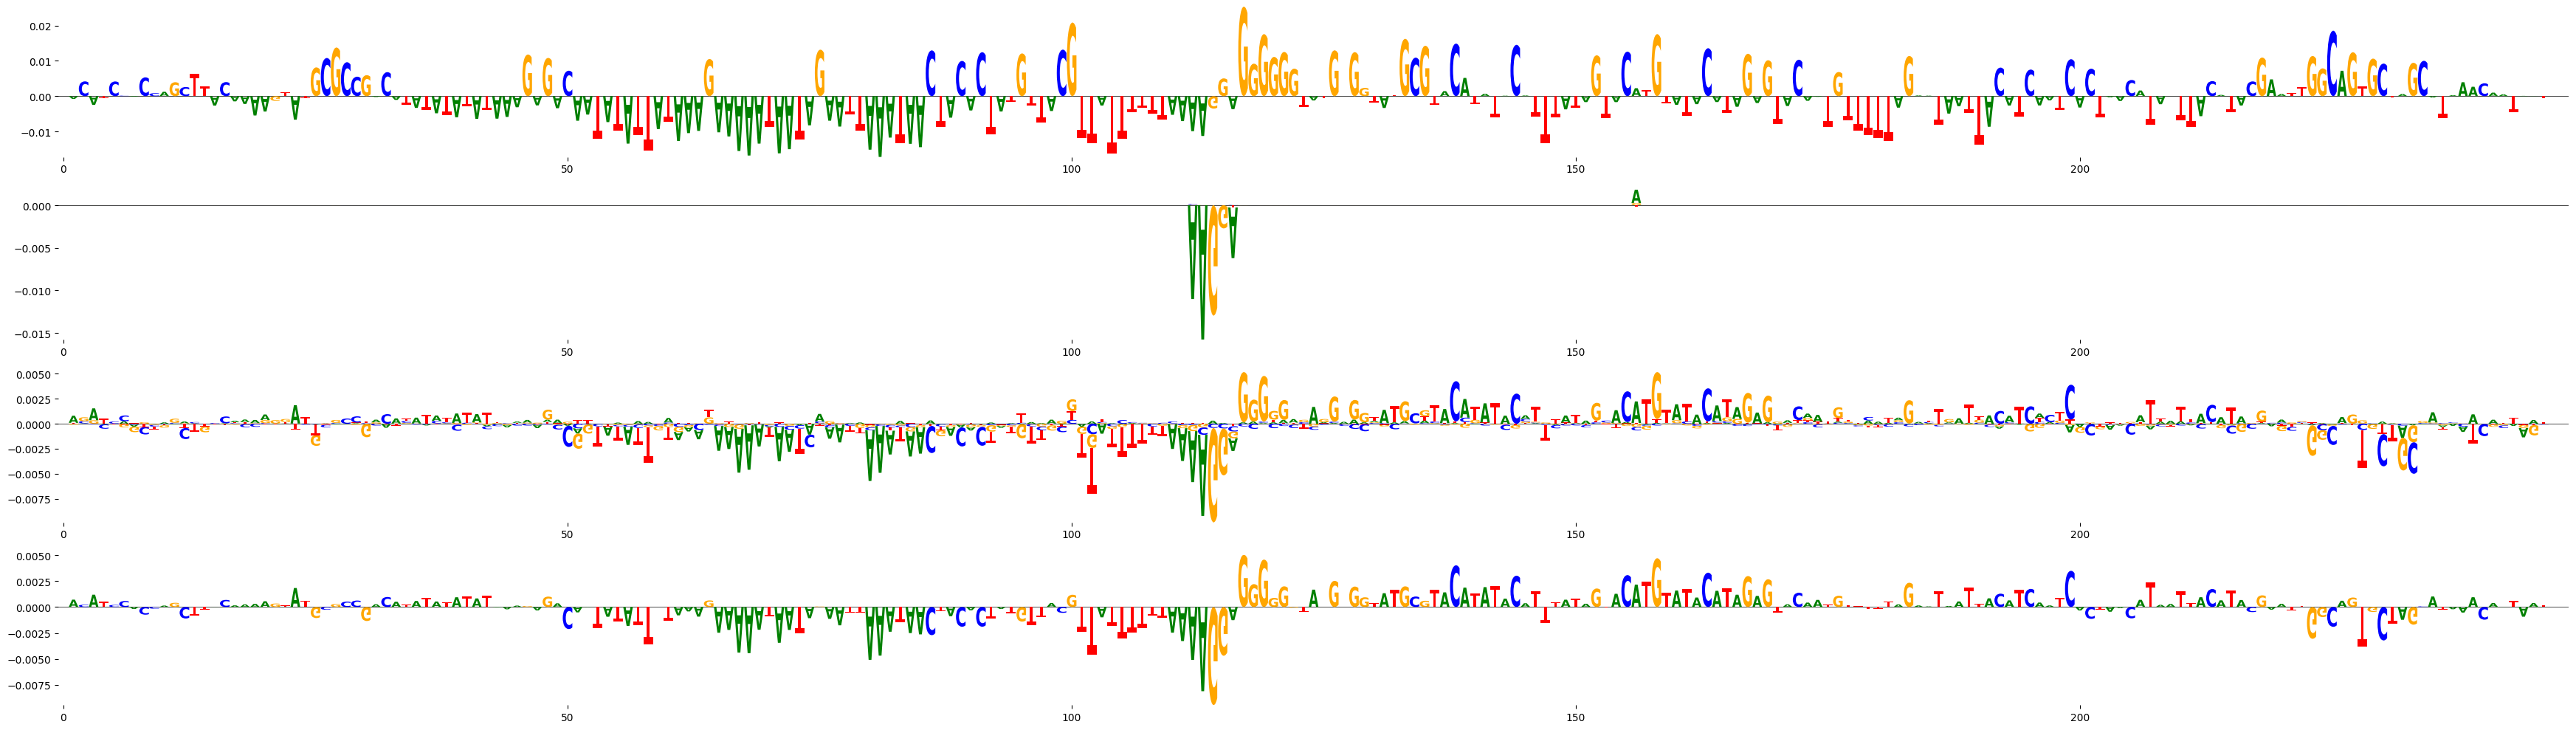

In [645]:
# NOTE: This cell has a different issue - it's using low_seqlets which has different indexing
# low_seqlets['example_idx'] refers to positions in the low_inXatt array (0-2999), not cleaned positions
seq_i = 1643  # This is a position in low_inXatt, not a cleaned position
# For low_seqlets, we need to map back to the correct sequence
# Find which low sequence this corresponds to
low_seqlets_for_seq = low_seqlets[low_seqlets['example_idx'] == seq_i]
if len(low_seqlets_for_seq) > 0:
    # Get the original sequence index from the low_seqlets
    # Note: This requires the mapping we created earlier
    print(f"Found {len(low_seqlets_for_seq)} seqlets for low position {seq_i}")
    # For now, let's use a different approach - find a sequence that exists
    seq_i = 0  # Use first low sequence as example
    print(f"Using low sequence position {seq_i} as example")

seq = orig_df.iloc[original_indices[low_cleaned_positions[seq_i]]]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=550,              # increased for H100 80GB
        n_shuffles=523                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

# FIXED: Use correct indexing for low_seqlets
plot_logo(attributions.T, ax=ax[0], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[low_cleaned_positions[seq_i]].T, ax=ax[1], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[low_cleaned_positions[seq_i]].T, ax=ax[2], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()

Cleaned position: 8888, Original sequence index: 8889
torch.Size([249, 4])


100%|██████████| 23/23 [00:00<00:00, 134.21it/s]


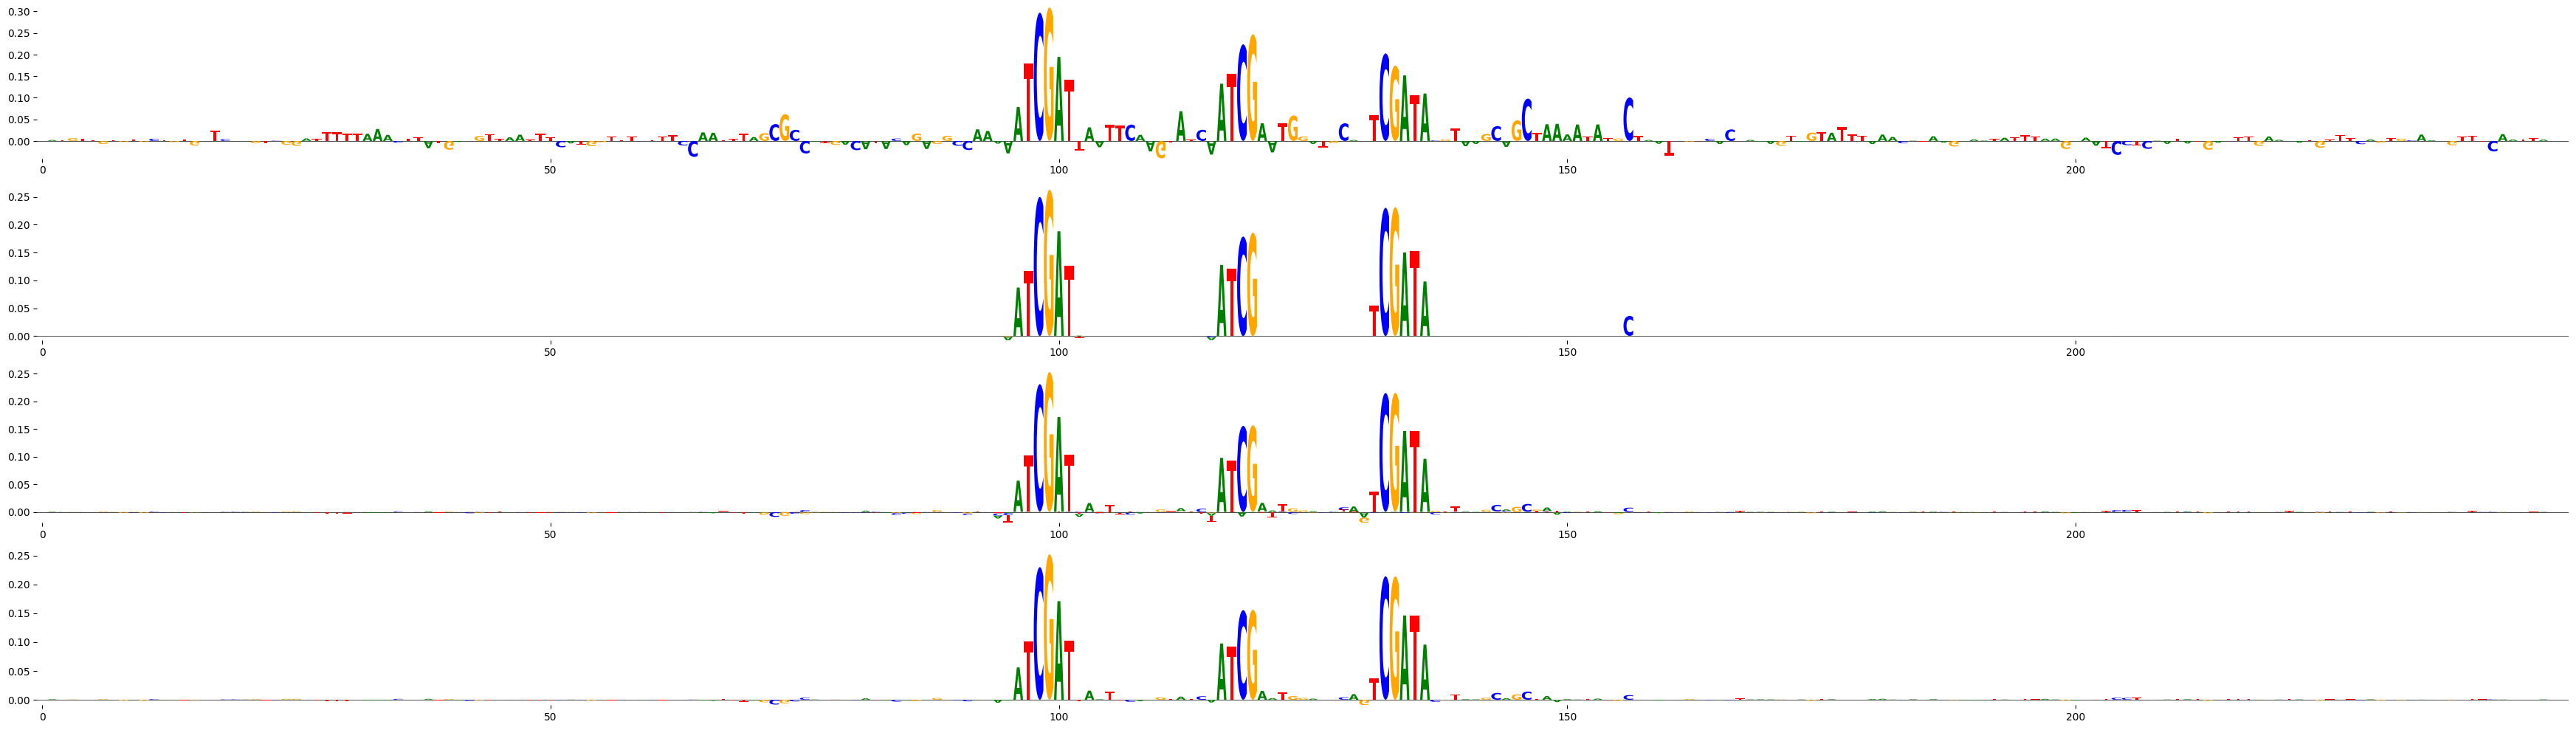

In [647]:
# FIXED VERSION: Correct indexing for high sequence numbers
seq_i = 8888  # This is a cleaned position (0-8998)
orig_seq_idx = index_mapping[seq_i]['original_sequence_idx']
print(f"Cleaned position: {seq_i}, Original sequence index: {orig_seq_idx}")
seq = orig_df.iloc[orig_seq_idx]['Sequence']
ohe_seq = one_hot_encode(seq).T
print(ohe_seq.shape)
attributions = deeplift_attr_with_progress(
        x_np_BLA=ohe_seq.unsqueeze(0),               # (N, L, A) np/int8 is fine
        target_idx=1,        # keep consistent with your Dev/HK
        batch_size=500,              # increased for H100 80GB
        n_shuffles=23                 # fewer shuffles for faster runtime
    ).astype(np.float16).squeeze(0)

fig, ax = plt.subplots(figsize=(35, 10), nrows=4)

# FIXED: Use consistent indexing
# seqlets['example_idx'] refers to cleaned positions, so use seq_i
# cluster_foreground_attr and scaled_foreground_attr are indexed by cleaned positions, so use seq_i  
# inXatt_4channel is indexed by original sequence indices, so use orig_seq_idx
plot_logo(attributions.T, ax=ax[0], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(cluster_foreground_attr[seq_i].T, ax=ax[1], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(scaled_foreground_attr[seq_i].T, ax=ax[2], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")
plot_logo(inXatt_4channel[seq_i].T, ax=ax[3], annotations=low_seqlets[low_seqlets['example_idx'] == seq_i], score_key="attribution")

plt.tight_layout()
plt.show()
